# Lecture 3: LSI Systems and Convolution in N-D

In [1]:
## MP 573 Lecture 3: LSI Systems and Convolution in N-D
##
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
import matplotlib.image as mpimg
from os.path import dirname, join as pjoin
from scipy import signal
import scipy.io as sio
from skimage.data import shepp_logan_phantom

# Q1: Create a synthetic image and pass it through several systems
In the next few cells, we will create a synthetic 2D signal (image) and pass it through several different systems as described in section 3.4. Make sure you understand the behavior of several of these example systems, particularly system F. 

For a convolution-based system such as example F, what will happen to large isolated features in the input image? What will happen to small, nearby features in the input image? 

A: They will all appear great, with no apparent blurring

B: Large isolated features will appear blurred, but still visible. In contrast, small nearby features will appear blurred and indistinguishable from each other, or may not be visible at all.

C: Features on the left side of the image will appear much clearer than those on the right side

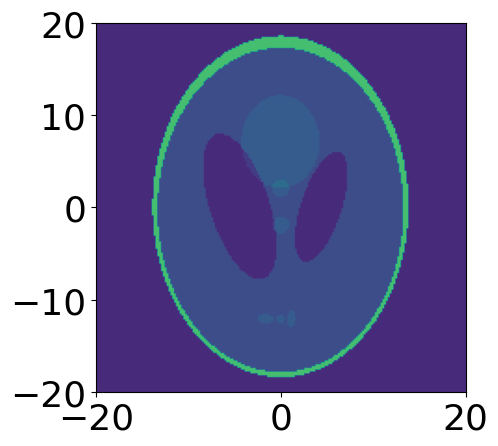

In [37]:
# Create a Shepp-Logan phantom image
f = shepp_logan_phantom()
f = f[2::2,2::2]
n = f.shape[1]
FOV = 40
y, x = np.mgrid[-FOV/2:FOV/2:(1j*n), -FOV/2:FOV/2:(1j*n)]

# Display the input image f
imgplot = plt.imshow(abs(f), extent = [-FOV/2, FOV/2, -FOV/2, FOV/2], vmin=-0.2, vmax = 1.5)
g = f[(abs(x)<0.001)*(abs(y)<0.001)] 

In [38]:
# Here is our system
def ExampleSystem(f,x,y,pickSystem):
    if pickSystem == 'A':
        g = f    # Example A from the lecture notes section 3.4
    elif pickSystem == 'B': 
        g = np.maximum(f,0) # Example B
    elif pickSystem == 'C': 
        g = np.abs(f) # Example C
    elif pickSystem == 'D': 
        g = f + 1 # Example D
    elif pickSystem == 'E': 
        g = f[(x==0)*(y==0)] + 0*f # Example E
    elif pickSystem == 'F': 
        h =  1.0*(np.abs(x)<=2)*(np.abs(y)<=2) # Example F
        h = h/np.sum(h) # Normalize the (discrete) filter to have sum = 1
        g = signal.convolve2d(h, f, mode='same') # Example F (cont)
#        g = (x[0,1]-x[0,0])*(y[1,0]-y[0,0])*signal.convolve2d(h, f, mode='same') # Example F (cont)
    elif pickSystem == 'G': 
        g = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(f)))/np.sqrt(len(f[:,1])*len(f[1,:]))
        # We will revisit example G (Fourier transform) in future lectures and exercises
    return (g)

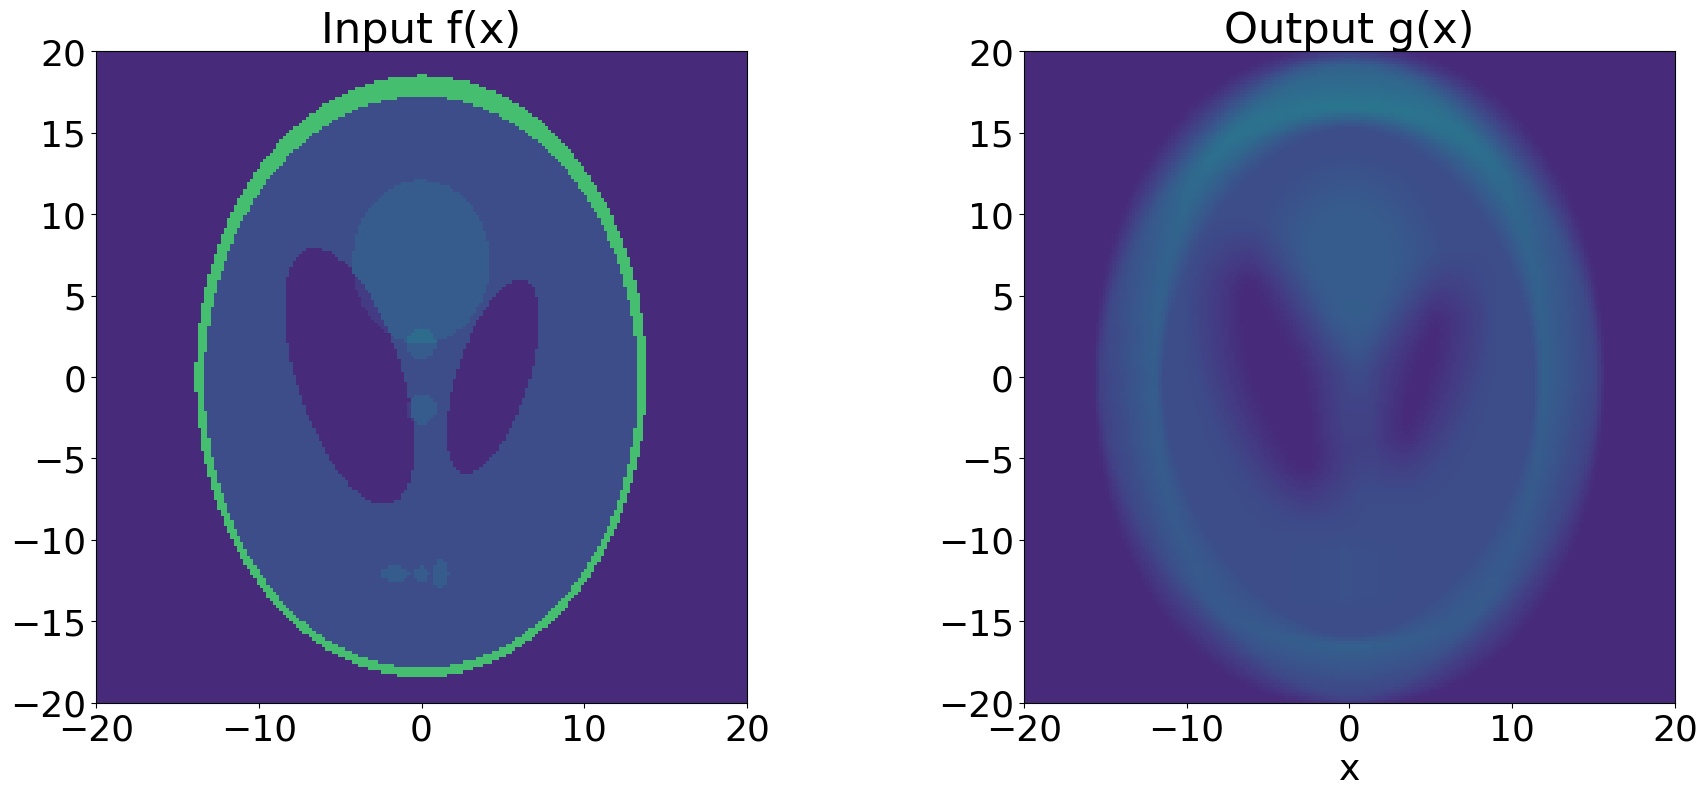

In [39]:
# Now let's run our signal through our system, and display the results
g = ExampleSystem(f,x,y,'F')

# Plot the input and output signals
font = {'weight' : 'normal',
        'size'   : 26}
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.rc('font', **font)
plt.imshow(np.real(f), extent = [-FOV/2, FOV/2, -FOV/2, FOV/2], vmin=-0.2, vmax = 1.5) # Showing real part in case it is complex
plt.title('Input f(x)')
plt.subplot(1,2,2)
plt.rc('font', **font)
plt.imshow(np.real(g), extent = [-FOV/2, FOV/2, -FOV/2, FOV/2], vmin=-0.2, vmax = 1.5) # Showing real part in case it is complex
plt.title('Output g(x)')
plt.xlabel('x')
plt.tight_layout(pad=4.0)

# Q2: Spatial resolution
Now let's assume that our system is an imaging device, it is linear and shift invariant, and it is characterized by a Gaussian-shaped impulse response. The input is the true underlying object we are trying to image (the 'perfect' image), and the output is the image produced by our system. Let us define spatial resolution as the minimum distance between two nearby point sources (delta functions) such that we can tell them apart in the resulting image. In other words, how close can two delta functions be such that they appear as two blobs in the resulting image, rather than a single big blob? So, what is the spatial resolution of our Gaussian system?

A: Approximately 1cm 

B: Approximately 3cm

C: Approximately 7cm

D: Approximately 10cm

In [121]:
def GaussianSystem(f,x,y):
    sigmax = 3
    sigmay = 3    
    h =  1.0*np.exp(-x*x/(2*sigmax*sigmax))*np.exp(-y*y/(2*sigmay*sigmay)) 
    g = (x[0,1]-x[0,0])*(y[1,0]-y[0,0])*signal.convolve2d(h, f, mode='same') 
    return (g)

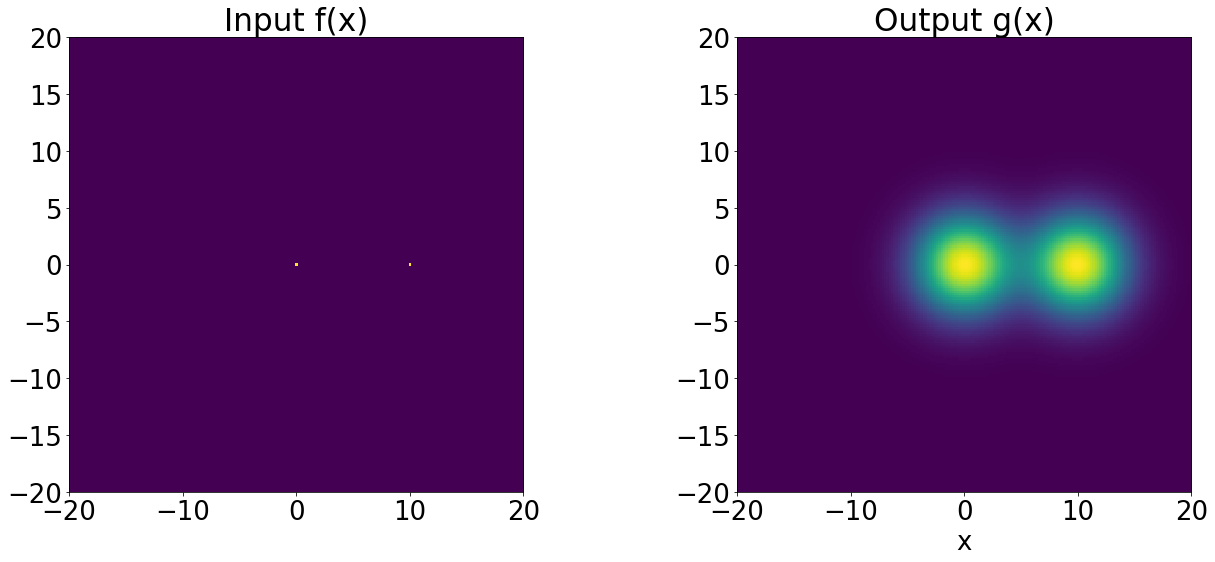

In [122]:
## Let's create some 2D signal with two delta functions
# Blank image
n = 201
p = np.zeros ((n, n))
FOV = 40

# Create the pixel grid and simple input image
y, x = np.mgrid[-40/2:40/2:(1j*n), -40/2:40/2:(1j*n)]
f = np.zeros ((n, n))
f[(abs(x-0)<0.001)*(abs(y-0)<0.001)] = 1 # Set a delta function at (0,0)
x0 = 10.0 # x location of second delta - needs to be multiple of 0.2
y0 = 0.0  # y location of second delta - needs to be multiple of 0.2
f[(abs(x-x0)<0.001)*(abs(y-y0)<0.001)] = 1 # Set another delta function at (x0,y0)

# Now let's run our signal through our system F
g = GaussianSystem(f,x,y)

# Plot the input and output signals
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.rc('font', **font)
plt.imshow(np.real(f), extent = [-FOV/2, FOV/2, -FOV/2, FOV/2]) # Showing real part in case it is complex
plt.title('Input f(x)')
plt.subplot(1,2,2)
plt.rc('font', **font)
plt.imshow(np.real(g), extent = [-FOV/2, FOV/2, -FOV/2, FOV/2]) # Showing real part in case it is complex
plt.title('Output g(x)')
plt.xlabel('x')
plt.tight_layout(pad=4.0)


# Q3: Non-zero output from zero input
We have a system such that for an input $f(\mathbf{r}) = 0$ it produces an output $g(\mathbf{r}) = 1$. Is it possible that this system is linear and shift-invariant? 

# Q4: Space-varying output from constant input
We have a system such that for an input $f(\mathbf{r}) = 1$ it produces an output $g(\mathbf{r}) =  \delta(\mathbf{r})$. Is it possible that this system is linear and shift-invariant? 